In [376]:
import requests
import matplotlib.pyplot as plt
import pandas as pd
import json
import ast
import seaborn as sns


In [377]:
# Criei uma função que pode ser utilizada para pesquisar qualquer produto desejado no Mercado Livre


def obter_resultados_busca(termo_pesquisa):
    url = f"https://api.mercadolibre.com/sites/MLB/search?q={termo_pesquisa}"
    response = requests.get(url)
    return response.json()

def salvar_resultados_em_csv(resultados, termo_pesquisa, nome_arquivo):
    dataframe = pd.json_normalize(resultados['results'])
    dataframe['Termo_Pesquisa'] = termo_pesquisa 
    dataframe.to_csv(nome_arquivo, index=False, encoding='utf-8')

if __name__ == "__main__":
    termo_de_pesquisa = input("Digite o termo de pesquisa: ")
    resultados = obter_resultados_busca(termo_de_pesquisa)

    print("Resposta completa da API:")
    print(pd.json_normalize(resultados['results']).to_string(index=False)) 

    salvar_resultados_em_csv(resultados, termo_de_pesquisa, 'dados_brutos.csv')
    print("Dados brutos salvos em 'dados_brutos.csv'.")



Resposta completa da API:
           id                                                                                              title condition                 thumbnail_id catalog_product_id listing_type_id                                                                                                                                    permalink buying_mode site_id category_id                               domain_id                                                      thumbnail currency_id  order_backend   price  original_price sale_price  available_quantity  official_store_id official_store_name  use_thumbnail_id  accepts_mercadopago                stop_time                                                                                                                                                                                                                                                                                                                                       

In [378]:
df = pd.read_csv('dados_brutos.csv')

A ideia inicial foi de puxar o data frame do API e salvar no formato CSV para permitir uma melhor visualização dos dados
A visualização foi dos dados foi necessária para que fosse possivel pensar qual direção era melhor seguir

O dataset é composto de 50 produtos (valor default da API) mas possui MUITAS colunas, várias delas vazias ou com informações pouco relevantes
Minha ideia inicial era de remover algumas dessas colunas, mas depois de alguns testes ficou claro que era melhor criar um dataframe novo contendo apenas oque era relevante

In [379]:
colunas_importantes = ['id', 'title', 'condition', 'price', 'original_price', 'available_quantity', 'attributes', 'shipping.free_shipping', 
                       'seller.nickname', 'shipping.logistic_type', 'installments.quantity', 'installments.amount', 'installments.rate']

try:
    df_novo = df[colunas_importantes].copy()
    print("DataFrame 'df_novo' criado com sucesso.")
except KeyError as e:
    print(f"Algumas colunas não existem no DataFrame original: {str(e)}")
    print("Criando DataFrame 'df_novo' sem essas colunas.")
    colunas_importantes = [
        'id', 'title', 'condition', 'price', 'original_price',
        'available_quantity', 'attributes', 'shipping.free_shipping',
        'seller.nickname', 'shipping.logistic_type'
    ]
    df_novo = df[colunas_importantes].copy()

if df_novo.empty:
    print("O DataFrame 'df_novo' está vazio.")

# Coloquei um try/except porque algumas pesquisas como "carro" não vão apresentar as colunas referentes a parcelamento
# Mesmo sem essas colunas eu quero que o dataframe seja criado e posteriormente analisado


DataFrame 'df_novo' criado com sucesso.


Após analisar com maior cuidado a coluna "attributes" percebi que ela contém informações potencialmente importantes

Mas que essas informações variam de produto para produto

Se eu fosse fazer uma análise mais aprofundada de um produto especifico, eu poderia pegar tamanho, cor, infantil ou adulto, modelo masculino ou feminino, etc...

Para fazer uma análise mais geral, decidi pegar um atributo que parece existir em todos produtos que eu pesquisei: BRAND

In [380]:
print(df_novo['attributes'].dtype)

object


In [381]:
# Como o tipo da variavel de 'attributes' deu object, tenho que transformar em string para utiliza-la

df_novo['attributes'] = df_novo['attributes'].astype(str)
df_novo['attributes'] = df_novo['attributes'].apply(ast.literal_eval)

# Função para extrair o 'value_name' quando 'id' é igual a 'BRAND'
def extrair_brand(attributes):
    for attribute in attributes:
        if attribute['id'] == 'BRAND':
            return attribute['value_name']
    return None

# Aplicar a função à coluna 'attributes' para criar uma nova coluna 'brand'
df_novo['brand'] = df_novo['attributes'].apply(extrair_brand)


In [382]:
df_limpo = df_novo.drop(columns=["attributes"])
print(df_limpo)
df_limpo.to_csv('df_limpo.csv', index=False, encoding='utf-8')
df_limpo.to_json('df_limpo.json', orient='records', lines=True)

               id                                              title  \
0   MLB3164501520  Fonte Stetsom 60a Bivolt Com Voltímetro Automo...   
1   MLB4390124138  Fonte 500w Fortrek Crusader Bivolt Atx Pc Game...   
2   MLB4377078840  Marcador Computador Velocímetro De Bike Sem Fi...   
3   MLB3230108347  Fonte Automotiva Chaveada 13v 90 Amperes + Vol...   
4   MLB3564258659  Fonte Thermaltake Toughpower 1050w Gf A3 80 Pl...   
5   MLB3387383905  Fonte Automotiva Stetsom Infinite 40a Bivolt C...   
6   MLB3601601259  Fonte Slim Driver Para Perfil Fita De Led 12v ...   
7   MLB3645780390  Fonte De Alimentação Para Pc C3tech C3plus Ps-...   
8   MLB4287897410  Fonte Carregador Jfa 36a Sci Voltímetro Bivolt...   
9   MLB2218354907  Fonte De Alimentação Para Pc Giga-byte Technol...   
10  MLB3597315627  Melhor Bombasss Submersa Para Aquaponia Hidrop...   
11  MLB3526685257  Fonte Automotiva Chaveada 14,4v 90a 1200w De P...   
12  MLB4370017694  Fonte P/ Tv 32 Un32j4000ag Un32j4290ag V32f39

Com isso vou calcular algumas medidas e depois fazer os gráficos
Em seguida vou testar l codgio com diversos produtos diferentes e ver se o codigo funciona para todos eles

In [383]:
df_limpo['price'].describe()


count      50.000000
mean      312.888000
std       332.420291
min        15.650000
25%        64.350000
50%       187.540000
75%       420.210000
max      1741.210000
Name: price, dtype: float64

In [384]:
df_limpo['brand'].value_counts()

brand
Spark                   6
Stetsom                 4
Knup                    3
Corsair                 2
RANGE PLANE             2
AquaPower Aquarismo     2
Fortrek                 2
JFA                     2
Vitafor                 1
Brazil PC               1
First Option            1
Dark Lab                1
Solucao                 1
Hoopson                 1
Cooler Master           1
Aikino                  1
K-Mex                   1
Taramps                 1
B-Max                   1
Astraled                1
Pcyes                   1
Usina                   1
Nova Voo                1
EK                      1
Jiaxi                   1
Multilaser              1
Digital                 1
ECOM ONLINE             1
Kaitai                  1
Giga-Byte Technology    1
C3Tech                  1
RY                      1
Thermaltake             1
Mariahzine              1
Power - Genérica        1
Name: count, dtype: int64

Agora que os dados estão tratados, tenho que pensar que tipo de análise é possível fazer com os dados obtidos.


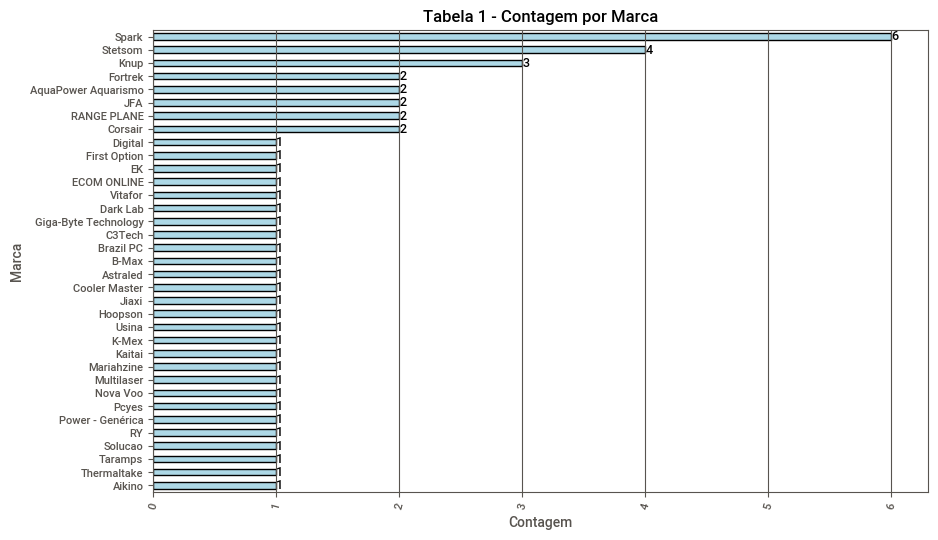

In [385]:

brand = df_limpo['brand']
contagem = df_limpo['brand'].value_counts()


df_prices = pd.DataFrame({'brand': contagem.index, 'contagem': contagem.values})

# Calcular a média de preço para cada marca
average_prices = df_prices.groupby('brand')['contagem'].mean()

# Ordenar as marcas em ordem descendente pela média de contagem
average_prices = average_prices.sort_values(ascending=True)

# Plotar um gráfico de barras para a média de contagem por marca
plt.figure(figsize=(10, 6))
bar_plot = average_prices.plot(kind='barh', edgecolor='black', color=['lightblue'])
plt.xlabel('Contagem')
plt.ylabel('Marca')
plt.title('Gráfico 1 - Contagem por Marca')
plt.xticks(rotation=75)
plt.grid(axis='x')



# Adicionar rótulos de barra
for container in bar_plot.containers:
    bar_plot.bar_label(container, label_type='edge', color='black', fontsize=9)

plt.show()





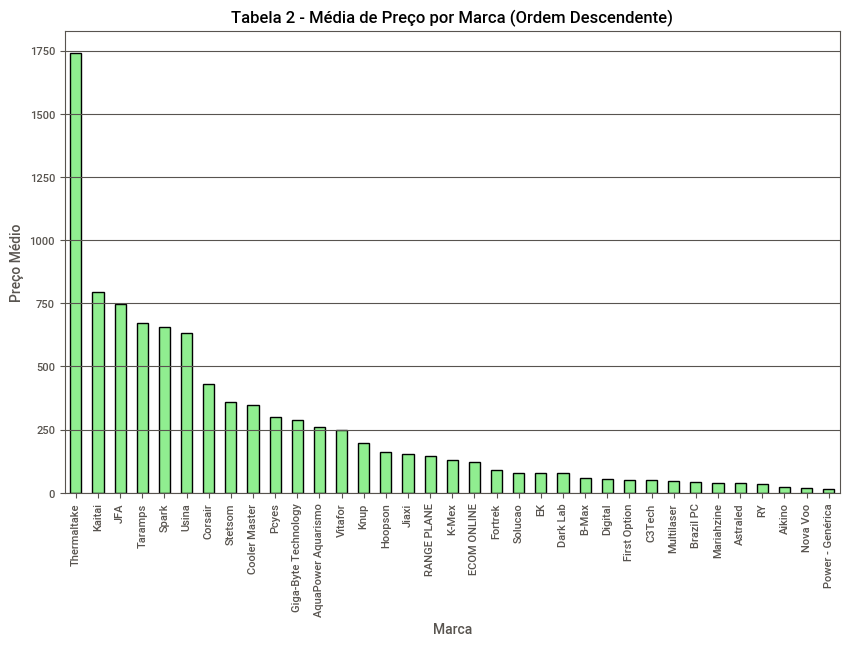

In [386]:
# Supondo que 'brand' seja a coluna de marcas e 'price' seja a coluna de preços
brand = df_limpo['brand']
price = df_limpo['price']

# Criar um DataFrame com as colunas 'brand' e 'price'
df_prices = pd.DataFrame({'brand': brand, 'price': price})

# Calcular a média de preço para cada marca
average_prices = df_prices.groupby('brand')['price'].mean()

# Ordenar as marcas em ordem descendente pela média de preço
average_prices = average_prices.sort_values(ascending=False)

# Vou plotar um gráfico de barras para a média de preço por marca
plt.figure(figsize=(10, 6))
average_prices.plot(kind='bar', edgecolor='black', color=['lightgreen'])
plt.xlabel('Marca')
plt.ylabel('Preço Médio')
plt.title('Gráfico 2 - Média de Preço por Marca (Ordem Descendente)')
plt.xticks(rotation=90)
plt.grid(axis='y')

plt.show()


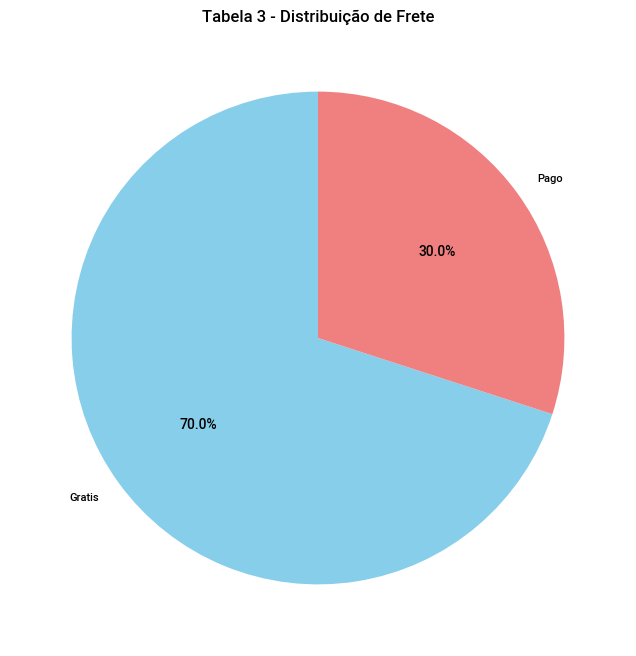

In [387]:
contagem_true_false = df_limpo['shipping.free_shipping'].value_counts()
rotulos_personalizados = {True: 'Gratis', False: 'Pago'}
df_limpo['shipping.free_shipping'] = df_limpo['shipping.free_shipping'].map(rotulos_personalizados)


contagem_true_false = df_limpo['shipping.free_shipping'].value_counts()


cores_personalizadas = {'Gratis': 'skyblue', 'Pago': 'lightcoral'}
plt.figure(figsize=(8, 8))
plt.pie(contagem_true_false, labels=contagem_true_false.index, autopct='%1.1f%%', startangle=90, colors=[cores_personalizadas[label] for label in contagem_true_false.index])
plt.title('Gráfico 3 - Distribuição de Frete')
plt.show()



Soma dos itens com frete grátis: 427.64657142857146
Soma dos itens com frete pago: 45.118


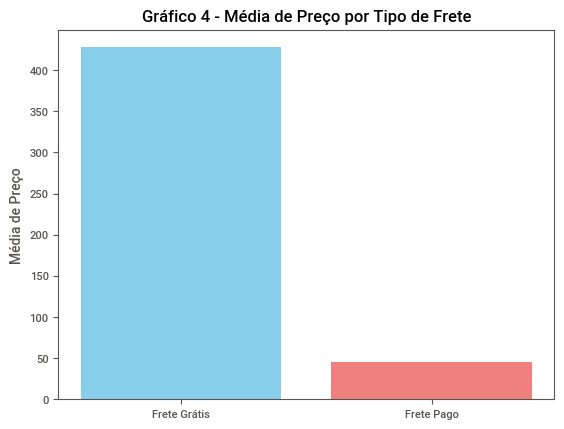

In [388]:
media_gratis = 0
media_pago = 0

media_gratis = df_limpo.loc[df_limpo['shipping.free_shipping'] == 'Gratis', 'price'].mean()
media_pago = df_limpo.loc[df_limpo['shipping.free_shipping'] == 'Pago', 'price'].mean()

print("Soma dos itens com frete grátis:", media_gratis)
print("Soma dos itens com frete pago:", media_pago)

categorias = ['Frete Grátis', 'Frete Pago']
medias = [media_gratis, media_pago]

cores_personalizadas = {'Gratis': 'skyblue', 'Pago': 'lightcoral'}
plt.bar(categorias, medias, color=[cores_personalizadas[label] for label in contagem_true_false.index])
plt.ylabel('Média de Preço')
plt.title('Gráfico 4 - Média de Preço por Tipo de Frete')
plt.show()

A ideia de fazer esses dois últimos gráfico era de análisar se haveria alguma diferença no preço médio dos produtos com frete grátis e pago
#
Foi possível perceber que quando comparados os preços médios dos produtros com frete pago e grátis, geralmente os produtos com frete grátis são mais caros
#
De fato, para produtos de ticket médio maior (celular, video game, drone...), o frete costuma ser gratis.

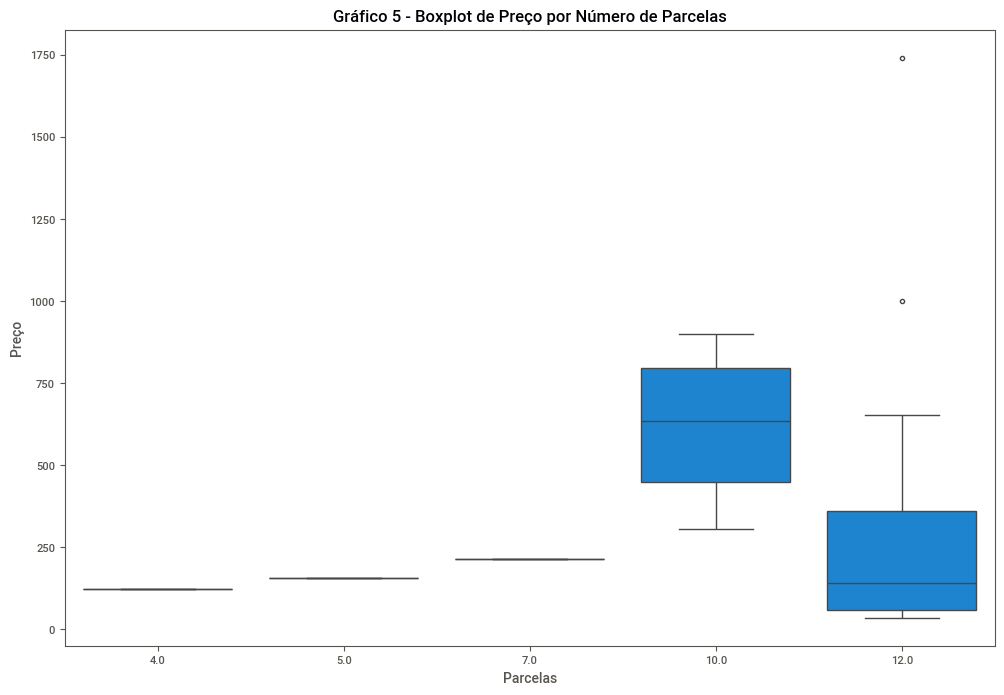

In [389]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='installments.quantity', y='price', data=df_limpo)
plt.title('Gráfico 5 - Boxplot de Preço por Número de Parcelas')
plt.xlabel('Parcelas')
plt.ylabel('Preço')
plt.show()

Aqui uma análise em boxplot para analizar se existe uma relação entre preço do produto e até quantas parcelas são aceitas

De maneira geral, existe uma relação direta entre o preço do produto e o número de parcelas

Quanto mais caro o produto, maior tende a ser o número de parcelas aceitas para o pagamento



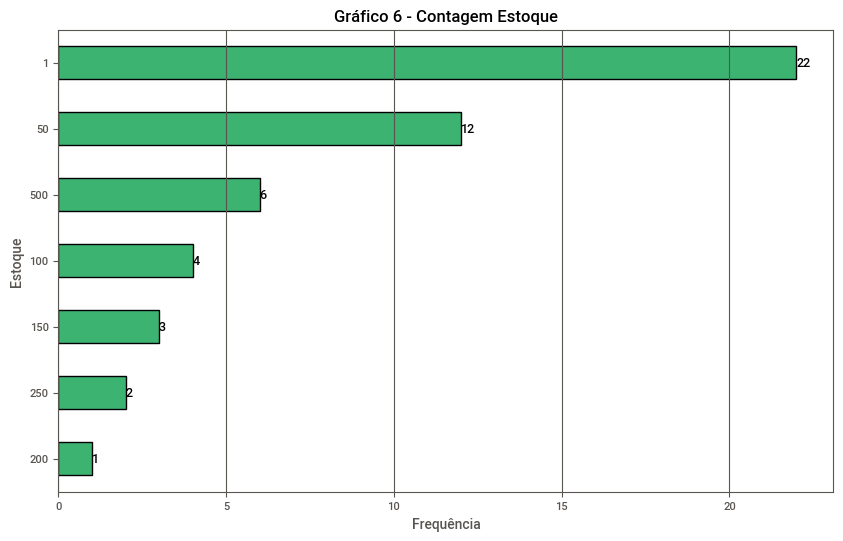

In [390]:
# Calcule a contagem
contagem_estoque = df_limpo['available_quantity'].value_counts().sort_values(ascending=True)

# Plote o gráfico
plt.figure(figsize=(10, 6))
bar_plot = contagem_estoque.plot(kind='barh', edgecolor='black', color=['mediumseagreen'])
plt.xlabel('Frequência')
plt.ylabel('Estoque')
plt.title('Gráfico 6 - Contagem Estoque')
plt.grid(axis='x')

# Adicione rótulos de barra
for container in bar_plot.containers:
    bar_plot.bar_label(container, label_type='edge', color='black', fontsize=9)

plt.show()





Por algum motivo o valor que parece repetir mais vezes é 1, e os demais valores encontrados geralmente são valores redondos como 100, 500 ou 1000

Provavelmente indicando que o vendedor coloca um valor inicial de estoque quando anuncia um produto e esse valor não é decrescido quando ocorrem vendas

De qualquer forma, os valores citados muito provavelmente não refletem os valores reais de estoque 

# Conclusão:
O preço do produto impacta fortemente no número de parcelas aceitas e na probabilidade de o frete ser grátis.

Com isso é possível dizer que em geral um produto barato vai ser parcelado em poucas parcelas e vai ter frete pago.

Enquanto que um produto mais caro vai ter mais parcelas e frete grátis, podemos deduzir que o preço do frete já esta imbutido no preço do produto 
Os valores de estoque geralmente é 1 ou valores redondos como 100, 500, 1000

Provavelmente indicando que o vendedor coloca um valor inicial de estoque quando anuncia um produto e esse valor não é decrescido quando ocorrem vendas 

Acredito que para evitar que o anúncio da venda caia automáticamente quando o estoque inicial chegue a zero 

Mas, colocar o estoque como 1 pode ser uma tática para gerar um gatilho de escassez falsa e gerar compras por impulso 